# Finding out the Waddington epigenetic landscape for various Gene Circuits.

In this python notebook, we basically try to find out the shape of a quasi-potential corresponding to various gene circuits, for the sake of replication of results, first we show the PES plotted for the tristable two variable system as shown in the paper.



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

## Initalizations to parameters that show good results

In [13]:

def initial_state():
        # Start timer
        start_time = time.time()

        # Parameters
        n = 4
        a1 = 10.0
        a2 = 10.0
        Kdxx = 4
        Kdyx = 4
        Kdyy = 4
        Kdxy = 4
        b1 = 10.0
        b2 = 10.0
        k1 = 1.0
        k2 = 1.0
        c1 = 0
        c2 = 0

        # First, generate potential surface from deterministic rate equations

        # Define grid spacing for "starting points" for each "path" on the potential surface
        xyGridSpacing = 2
        x_lim = 40.0  # upper limit of x, y (zero to ...)
        y_lim = 40.0

        # Number of time steps for integrating along each path (ensure uniform arrays)
        numTimeSteps = 1400  # Choose high-enough number for convergence with given dt

        # Time step and tolerance to test for convergence
        dt = 1.0e-2  # ** Check convergence for assigned "numTimeSteps" and tol
        tol = 1.0e-4  # **

        # Calculate total number of paths for defined grid spacing
        x_values = np.arange(0, x_lim + xyGridSpacing, xyGridSpacing)
        y_values = np.arange(0, y_lim + xyGridSpacing, xyGridSpacing)
        numPaths = len(x_values) * len(y_values)

        # Initialize "path" variable matrices
        x_path = np.zeros((numPaths, numTimeSteps))  # x-coordinate along path
        y_path = np.zeros((numPaths, numTimeSteps))  # y-coordinate along path
        pot_path = np.zeros((numPaths, numTimeSteps))  # potential along path

        path_tag = np.ones(numPaths, dtype=int)  # tag for given path (to denote basin of attraction)

        # Initialize "Path counter" to 0
        path_counter = 0

        # Initialize number of attractors and separatrices (basin boundaries)
        num_attractors = 0
        num_sepx = 0

        # Arrays to keep track of attractors and their coordinates; and potential
        attractors_num_X_Y = []
        attractors_pot = []

        # Array to keep track of number of paths per attractor
        numPaths_att = []

        # Array to keep track of separatrices
        sepx_old_new_pathNum = []
        return(x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing, path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot, numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt, tol)


## A function to choose the governing differential system for the two concentrations.

In [14]:

def diff_eqn_system(x_p,y_p,system,a1,a2,Kdxx,Kdyx,Kdyy,Kdxy,b1,b2,k1,k2,c1,c2,n):
    if(system=="TriStable Switch"):
        dxdt = c1 + a1 * (x_p**n) / (Kdxx**n + x_p**n) + b1 * (Kdyx**n) / (Kdyx**n + y_p**n) - k1 * x_p
        dydt = c2 + a2 * (y_p**n) / (Kdyy**n + y_p**n) + b2 * (Kdxy**n) / (Kdxy**n + x_p**n) - k2 * y_p
    elif(system=="BiStable Switch"):
        dxdt = c1 + b1 * (Kdyx**n) / (Kdyx**n + y_p**n) - k1 * x_p
        dydt = c2 + b2 * (Kdxy**n) / (Kdxy**n + x_p**n) - k2 * y_p
    elif(system=="Oscillator"):
        #x activating y , and y inhibiting x
        dxdt = c1 + b1 * (Kdyx**n) / (Kdyx**n + y_p**n) - k1 * x_p
        dydt = c2 + a2 * (y_p**n) / (Kdyy**n + y_p**n) - k2 * y_p
    return dxdt,dydt   


## Computation of the quasi-potential

In [15]:
def compute_potential_surface(x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, 
                              path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot, numPaths_att, sepx_old_new_pathNum,
                                start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt, tol,n,system):
    for i in x_values:
        for j in y_values:
            x0 = i
            y0 = j


            Pot = 0  
            Pot_old = 1.0e7  

            x_p = x0
            y_p = y0

            x_path[path_counter, 0] = x_p
            y_path[path_counter, 0] = y_p
            pot_path[path_counter, 0] = Pot

            for n_steps in range(1, numTimeSteps):
                Pot_old = Pot
                dxdt, dydt = diff_eqn_system(x_p,y_p,system,a1,a2,Kdxx,Kdyx,Kdyy,Kdxy,b1,b2,k1,k2,c1,c2,n)
                dx = dxdt * dt
                dy = dydt * dt
                x_p += dx
                y_p += dy

                x_path[path_counter, n_steps] = x_p
                y_path[path_counter, n_steps] = y_p
                dPot = -dxdt * dx - dydt * dy  ## formula from the paper
                Pot += dPot
                pot_path[path_counter, n_steps] = Pot

            if path_counter == 0:
                num_attractors += 1
                attractors_num_X_Y.append([num_attractors, x_p, y_p])
                attractors_pot.append(Pot)
                path_tag[path_counter] = num_attractors
                numPaths_att.append(1)
            else:
                path_tag[path_counter] = path_tag[path_counter - 1]

                x0_lastPath = x_path[path_counter - 1, 0]
                y0_lastPath = y_path[path_counter - 1, 0]

                xp_lastPath = x_path[path_counter - 1, -1]
                yp_lastPath = y_path[path_counter - 1, -1]

                pot_p_lastPath = pot_path[path_counter - 1, -1]
                startPt_dist_sqr = (x0 - x0_lastPath) ** 2 + (y0 - y0_lastPath) ** 2
                endPt_dist_sqr = (x_p - xp_lastPath) ** 2 + (y_p - yp_lastPath) ** 2

                if endPt_dist_sqr > (2 * (xyGridSpacing ** 2)):
                    new_attr_found = True
                    for k in range(num_attractors):
                        x_att = attractors_num_X_Y[k][1]
                        y_att = attractors_num_X_Y[k][2]
                        if abs(x_p - x_att) < xyGridSpacing and abs(y_p - y_att) < xyGridSpacing:
                            new_attr_found = False
                            path_tag[path_counter] = k + 1
                            numPaths_att[k] += 1
                            break

                    if new_attr_found:
                        num_attractors += 1
                        attractors_num_X_Y.append([num_attractors, x_p, y_p])
                        path_tag[path_counter] = num_attractors
                        numPaths_att.append(1)
                        if startPt_dist_sqr < (2 * (xyGridSpacing ** 2)):
                            curr_sepx = [path_tag[path_counter - 1], path_tag[path_counter], path_counter - 1]
                            sepx_old_new_pathNum.append(curr_sepx)
                            attractors_pot.append(Pot)
                            num_sepx += 1
                    else:
                        prev_attr_new = True
                        for k in range(num_sepx):
                            attr1 = sepx_old_new_pathNum[k][0]
                            attr2 = sepx_old_new_pathNum[k][1]
                            if path_tag[path_counter - 1] == attr1 or path_tag[path_counter - 1] == attr2:
                                prev_attr_new = False
                                break

                        if prev_attr_new:
                            if startPt_dist_sqr < (2 * (xyGridSpacing ** 2)):
                                curr_sepx = [path_tag[path_counter - 1], path_tag[path_counter], path_counter - 1]
                                sepx_old_new_pathNum.append(curr_sepx)
                                attractors_pot.append(pot_p_lastPath)
                                num_sepx += 1
                else:
                    tag = path_tag[path_counter]
                    numPaths_att[tag - 1] += 1  

            
            path_counter += 1

    print('Ran path-loop okay!')
    print(num_attractors, 'attractors identified')
    print(num_sepx, 'separatrices identified')
    print('************************')

    x_p_list = x_path.flatten()
    y_p_list = y_path.flatten()
    pot_p_list = pot_path.flatten()
    return(x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps)


In [16]:

def plot_potential_surface(x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps):
    for n_path in range(numPaths):
        tag = path_tag[n_path]
        del_pot = pot_path[n_path, -1] - attractors_pot[tag - 1]
        pot_path[n_path, :] -= del_pot

        idx_start = n_path * numTimeSteps
        idx_end = idx_start + numTimeSteps
        pot_p_list[idx_start:idx_end] = pot_path[n_path, :]

    print('Ran path-alignment okay!')
    print('************************')

    grid_lines = 100  
    xlin = np.linspace(np.min(x_p_list), np.max(x_p_list), grid_lines)
    ylin = np.linspace(np.min(y_p_list), np.max(y_p_list), grid_lines)
    Xgrid, Ygrid = np.meshgrid(xlin, ylin)
    Zgrid = griddata((x_p_list, y_p_list), pot_p_list, (Xgrid, Ygrid), method='cubic') 

    print('Ran surface grid-interpolation okay!')
    print('************************************')

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(Xgrid, Ygrid, Zgrid, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.contour(Xgrid, Ygrid, Zgrid, 45, offset=np.min(Zgrid) - 0.5, cmap='viridis')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('Potential', fontsize=12)
    ax.view_init(elev=30, azim=-60)  
    path_spacing = 4
    for n_path in range(numPaths):
        x_start = x_path[n_path, 0]
        y_start = y_path[n_path, 0]
        if ((x_start % path_spacing == 0 and y_start % path_spacing == 0) or
                (y_start % path_spacing == 0 and x_start % path_spacing == 0)):
            if path_tag[n_path] == 1:
                color = 'r'
            elif path_tag[n_path] == 2:
                color = 'b'
            elif path_tag[n_path] == 3:
                color = 'g'
            else:
                color = 'k'
            ax.plot(x_path[n_path, :], y_path[n_path, :], pot_path[n_path, :], '-', color=color, linewidth=1)

    # Run stochastic simulations
    return(ax)

In [17]:
n=5

Ran path-loop okay!
3 attractors identified
2 separatrices identified
************************
Ran path-alignment okay!
************************
Ran surface grid-interpolation okay!
************************************


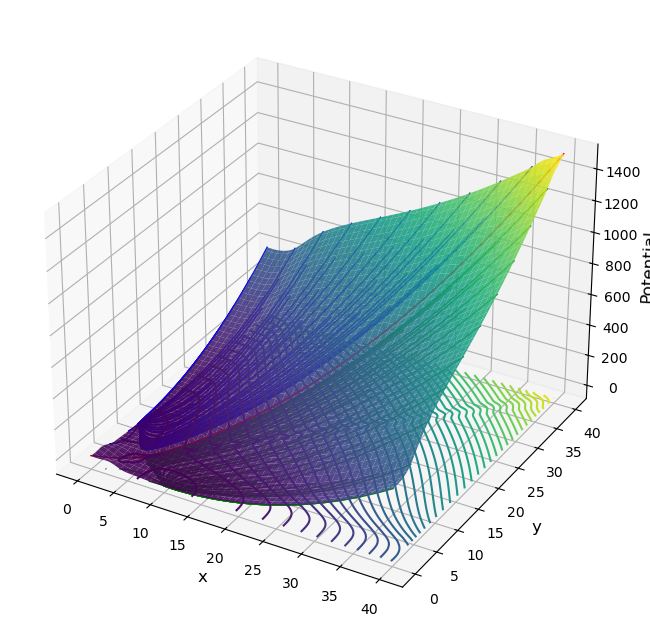

In [18]:
x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot, numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt, tol = initial_state()
x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps = compute_potential_surface(x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot,
                                                          numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt,tol,n,"BiStable Switch")
ax = plot_potential_surface(x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps)

Ran path-loop okay!
3 attractors identified
2 separatrices identified
************************
Ran path-alignment okay!
************************
Ran surface grid-interpolation okay!
************************************


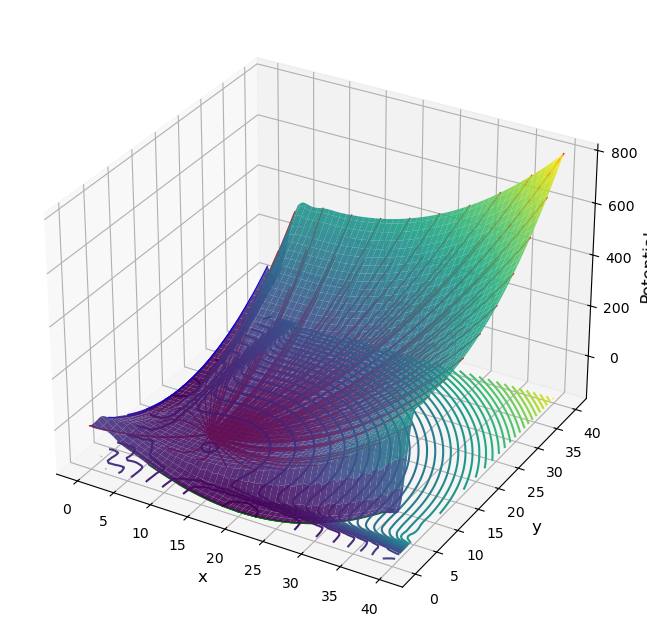

In [19]:
x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot, numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt, tol = initial_state()
x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps = compute_potential_surface(x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot,
                                                          numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt,tol,n,"TriStable Switch")
ax = plot_potential_surface(x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps)

Ran path-loop okay!
2 attractors identified
1 separatrices identified
************************
Ran path-alignment okay!
************************
Ran surface grid-interpolation okay!
************************************


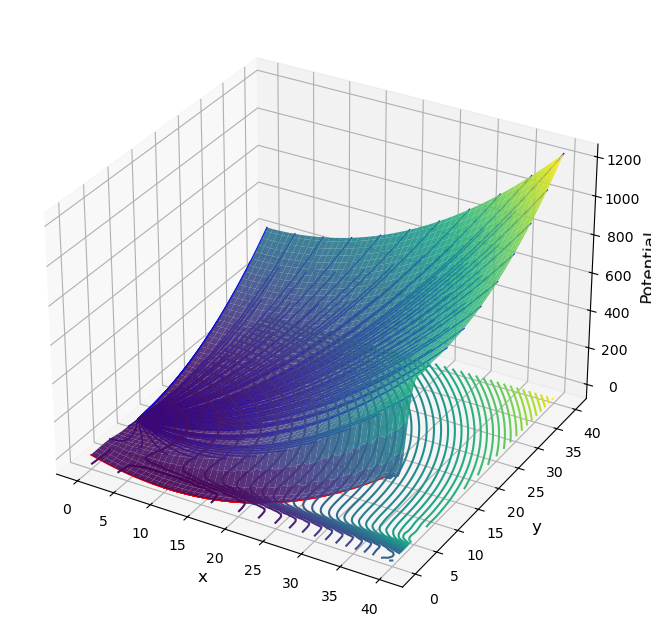

In [20]:
x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot, numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt, tol = initial_state()
x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps = compute_potential_surface(x_values, y_values, numPaths, x_path, y_path, pot_path,xyGridSpacing ,path_tag, path_counter, num_attractors, num_sepx, attractors_num_X_Y, attractors_pot,
                                                          numPaths_att, sepx_old_new_pathNum, start_time, a1, a2, Kdxx, Kdyx, Kdyy, Kdxy, b1, b2, k1, k2, c1, c2, x_lim, y_lim, numTimeSteps, dt,tol,n,"Oscillator")
ax = plot_potential_surface(x_p_list,y_p_list,pot_p_list,numPaths,x_path,y_path,pot_path,path_tag,attractors_pot,numTimeSteps)

In [ ]:
num_of_cells = 1000
x_array = np.zeros(num_of_cells)
y_array = np.zeros(num_of_cells)
pot_array_stoch = np.zeros(num_of_cells)
num_cells_blue = 0
num_cells_red = 0
num_cells_green = 0

def sde_system(state):
    x_p, y_p = state
    dxdt,dydt = diff_eqn_system(x_p,y_p,"TriStable Switch",a1,a2,Kdxx,Kdyx,Kdyy,Kdxy,b1,b2,k1,k2,c1,c2,n)
    return np.array([dxdt, dydt])

def simulate_stochastic(initial_state, t_max, dt):
    num_steps = int(t_max / dt)
    x = np.zeros((num_steps, 2))
    x[0, :] = initial_state
    for i in range(1, num_steps):
        x_prev = x[i - 1, :]
        dxdt = sde_system(x_prev)
        
        # Calculate noise intensity based on reaction rates (multiplicative noise)
        noise_intensity = np.sqrt(np.abs(dxdt * dt))
        noise = np.random.normal(0.0, 1.0, size=2) * noise_intensity
        
        x_new = x_prev + dxdt * dt + noise
        # Ensure non-negative concentrations
        x_new = np.maximum(x_new, 0)
        x[i, :] = x_new
    return x[-1, :]

print('Running stochastic simulations...')
for i in range(num_of_cells):
    if i % 100 == 0:
        print(f'Cell #{i}')

    initial_state = np.random.uniform(0, 40, size=2)
    t_max = 100  
    dt_stoch = 0.01  
    x_endVal, y_endVal = simulate_stochastic(initial_state, t_max, dt_stoch)
    x_endVal += 0.1 + np.random.rand() * 0.5
    y_endVal += 0.1 + np.random.rand() * 0.5
    x_array[i] = x_endVal
    y_array[i] = y_endVal
    x_stoch = x_array[i]
    y_stoch = y_array[i]
    dist_sqr = ((x_p_list - x_stoch) ** 2 + (y_p_list - y_stoch) ** 2)
    idx = np.argsort(dist_sqr)[:2]

    x_path_1 = x_p_list[idx[0]]
    x_path_2 = x_p_list[idx[1]]

    y_path_1 = y_p_list[idx[0]]
    y_path_2 = y_p_list[idx[1]]

    pot_path_1 = pot_p_list[idx[0]]
    pot_path_2 = pot_p_list[idx[1]]
    x_diff = x_path_2 - x_path_1
    y_diff = y_path_2 - y_path_1

    if abs(x_diff) >= 1.0e-2:
        p_stoch = ((x_stoch - x_path_1) / x_diff) * (pot_path_2 - pot_path_1) + pot_path_1
    elif abs(y_diff) >= 1.0e-2:
        p_stoch = ((y_stoch - y_path_1) / y_diff) * (pot_path_2 - pot_path_1) + pot_path_1
    else:
        p_stoch = pot_path_1

    pot_array_stoch[i] = p_stoch
    # basically say what element fell into what basin, based on the potential value
    if x_array[i] < 5 and y_array[i] > 5:
        num_cells_blue += 1
    elif x_array[i] > 5 and y_array[i] < 5:
        num_cells_green += 1
    else:
        num_cells_red += 1